In [1]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.8 MB/s eta 0:00:00


In [2]:
# 1. connect file drive
from google.colab import drive
drive.mount('/content/drive')
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# plt.style.use('dark_background')

from statsmodels.tsa.stattools import adfuller  # kiểm tra chuỗi có tính dừng không -> có phụ thuộc vào thời gian chạy không?
from statsmodels.tsa.seasonal import seasonal_decompose   # phân tích -> thành phần chuỗi gốc, thành phần xu hướng, thành phần mùa vụ và thành phần nhiễu

from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_log_error, mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

Mounted at /content/drive


In [3]:
# 2. Đọc file csv
# company_csv = '/content/drive/MyDrive/Colab Notebooks/Datacrawl/IMP.csv'
company_csv = '/content/drive/My Drive/data1/VCB_Stock_Data.csv'
# company_csv = '/content/drive/MyDrive/Colab Notebooks/Datacrawl/VMD.csv'
data = pd.read_csv(company_csv)
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/27/2014,12352807617,12352807617,12181833984,12181833984,12181833984,1740361
1,2/6/2014,12181833984,12181833984,11882630859,11925374023,11925374023,2882673
2,2/7/2014,11968117188,12053604492,11839887695,11882630859,11882630859,1889556
3,2/10/2014,11925374023,12096347656,11839887695,12096347656,12096347656,1143474
4,2/11/2014,12139090820,12224577148,12053604492,12096347656,12096347656,2232159
...,...,...,...,...,...,...,...
2454,12/7/2023,85700000000,86000000000,85000000000,85200000000,85200000000,2403460
2455,12/8/2023,85200000000,85500000000,85000000000,85000000000,85000000000,1293000
2456,12/11/2023,85000000000,85300000000,84100000000,84200000000,84200000000,2768100
2457,12/12/2023,84700000000,84700000000,84000000000,84200000000,84200000000,1148400


In [4]:
# 2. Đọc file dữ liệu và chia train test  theo tỉ lệ 9:1
df = pd.read_csv(company_csv)
df = df[['Close']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing.
train_size = int(0.9* len(df))
test_size = len(df)-train_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])
exog_train = np.arange(len(train_data))

In [5]:
model_autoARIMA = auto_arima(y_train,start_p=0, start_q=0,
                           max_p=5, max_q=5, m=12,
                           start_P=0, seasonal=False,
                           d=0, D=0, trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True,
                      exogenous= data[['High','Open','Low']][:len(y_train)])

model_autoARIMA.summary()

/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=114809.404, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.55 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=113172.463, Time=0.41 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=97160.401, Time=0.77 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=97163.447, Time=1.04 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=97162.313, Time=1.20 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=112779.209, Time=0.50 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=1.58 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=97163.951, Time=3.74 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=97161.786, Time=2.68 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 12.629 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2213
Model:               SARIMAX(1, 0, 1)   Log Likelihood              -48577.200
Date:                Sat, 30 Dec 2023   AIC                          97160.401
Time:                        18:21:51   BIC                          97177.507
Sample:                             0   HQIC                         97166.650
                               - 2213                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9998      0.000   4137.144      0.000       0.999       1.000
ma.L1          0.0231      0.014      1.622      0.105      -0.005       0.051
sigma2      6.803e+17    1.2e-21   5.65e+38      0.000     6.8e+17     6.8e+17
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1811.92
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               8.27   Skew:                            -0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.55e+55. Standard errors may be unstable.
"""

In [6]:
model = ARIMA(y_train, order=(2,0,1),exog=data[['High','Open','Low']][:len(y_train)]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2213
Model:                 ARIMA(2, 0, 1)   Log Likelihood              -46934.062
Date:                Sat, 30 Dec 2023   AIC                          93884.125
Time:                        18:21:58   BIC                          93929.742
Sample:                             0   HQIC                         93900.789
                               - 2213                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.979e+07   1.33e-10  -3.73e+17      0.000   -4.98e+07   -4.98e+07
High           0.8246      0.008    101.145      0.000       0.809       0.841
Open          -0.4486      0.009    -49.991      0.000      -0.466      -0.431
Low            0.6231      0.009     71.787      0.000       0.606       0.640
ar.L1          0.6254      0.150      4.166      0.000       0.331       0.920
ar.L2          0.0297      0.018      1.661      0.097      -0.005       0.065
ma.L1         -0.5969      0.148     -4.043      0.000      -0.886      -0.308
sigma2      1.549e+17   7.86e-19   1.97e+35      0.000    1.55e+17    1.55e+17
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3987.76
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):              11.15   Skew:                            -0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number  8e+50. Standard errors may be unstable.
"""

In [7]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(start=int(x_test[0]), end=int(len(x_test)+x_test[0]-1),exog=data[['High','Open','Low']][int(x_test[0]):int(len(x_test)+x_test[0])])
from sklearn.metrics import mean_absolute_percentage_error,mean_absolute_error
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, mean_absolute_percentage_error
# 7. Đánh giá độ chính xác test bằng RMSE, MAE , MAPE
# RMSE
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Testing RMSE:', test_rmse)
# MAPE
test_mape = mean_absolute_percentage_error(y_test,y_pred)
print('Testing MAPE:', test_mape)
# Calculate MSLE
test_msle = mean_squared_log_error(y_test, y_pred)
print('Testing MSLE:', test_msle)


Testing RMSE: 582159735.3590295
Testing MAPE: 0.005767103884430674
Testing MSLE: 5.5517550449299426e-05


Predicted closing prices for the next 30 days:
2459    8.705503e+10
2460    8.781772e+10
2461    8.863354e+10
2462    8.925747e+10
2463    8.867570e+10
2464    8.920493e+10
2465    8.836707e+10
2466    8.661076e+10
2467    8.557598e+10
2468    8.590582e+10
2469    8.735639e+10
2470    8.750407e+10
2471    8.631502e+10
2472    8.624833e+10
2473    8.627510e+10
2474    8.599845e+10
2475    8.590146e+10
2476    8.546861e+10
2477    8.530660e+10
2478    8.526153e+10
2479    8.549332e+10
2480    8.496638e+10
2481    8.435243e+10
2482    8.555377e+10
2483    8.520214e+10
2484    8.555833e+10
2485    8.537888e+10
2486    8.519090e+10
2487    8.455494e+10
2488    8.413247e+10
Name: predicted_mean, dtype: float64


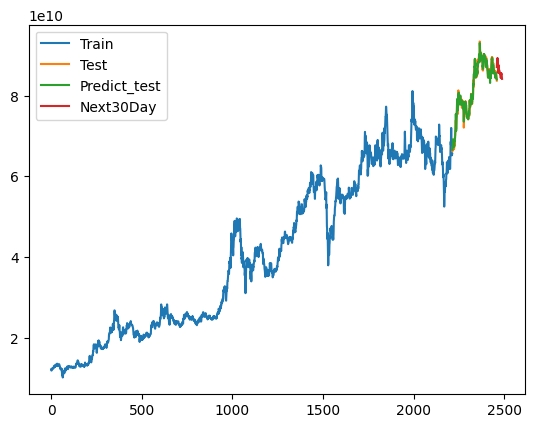

In [9]:
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)
# Assuming 'data' is your training data, replace it with your actual training data
exog_data = data[['High', 'Open', 'Low']][last_index - 523:last_index]

y_next_30_days = model.predict(start=int(x_next_30_days[0]), end=int(len(x_next_30_days) + x_next_30_days[0] - 1),
                               exog=data[['High','Open','Low']][last_index-276:last_index])

print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)


plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predict_test','Next30Day'])
plt.show()